###### Importing necessary libraries

In [2]:
from utils import pickle_to, pickle_from
import numpy as np
import sys
import pandas as pd
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn import metrics
from sklearn.linear_model import LogisticRegressionCV
from sklearn.model_selection import cross_val_score
import matplotlib.pyplot as plt
import seaborn as sns
from sklearn.feature_extraction.text import CountVectorizer

pd.set_option('display.max_colwidth', -1)


##### To ignore warning messages

In [3]:
if not sys.warnoptions:
    import os, warnings
    warnings.simplefilter("ignore") # Change the filter in this process
    os.environ["PYTHONWARNINGS"] = "default" # Also affect subprocesses

# Unpickling necessary objects

In [4]:
X_tr_val = pickle_from('../data/processed/X_tr_val.pkl')
y_tr_val = pickle_from('../data/processed/y_tr_val.pkl')
X_test = pickle_from('../data/processed/X_test.pkl')
y_test = pickle_from('../data/processed/y_test.pkl')
X_train = pickle_from('../data/processed/X_train.pkl')
y_train = pickle_from('../data/processed/y_train.pkl')


Loaded file from ../data/processed/X_tr_val.pkl
Loaded file from ../data/processed/y_tr_val.pkl
Loaded file from ../data/processed/X_test.pkl
Loaded file from ../data/processed/y_test.pkl
Loaded file from ../data/processed/X_train.pkl
Loaded file from ../data/processed/y_train.pkl


# Test set

Training the model on the entire training set and testing on test set


In [7]:
c_bool = CountVectorizer(tokenizer=lambda doc: doc, lowercase=False,binary ='boolean')

#Fit count vectorizer to training data
c_bool.fit(X_tr_val)
c_bool.fit(X_tr_val)

CountVectorizer(analyzer='word', binary='boolean', decode_error='strict',
        dtype=<class 'numpy.int64'>, encoding='utf-8', input='content',
        lowercase=False, max_df=1.0, max_features=None, min_df=1,
        ngram_range=(1, 1), preprocessor=None, stop_words=None,
        strip_accents=None, token_pattern='(?u)\\b\\w\\w+\\b',
        tokenizer=<function <lambda> at 0x1a2ec566a8>, vocabulary=None)

In [8]:
# Transform training and test data into count vectors
X_tr_val_bool = c_bool.transform(X_tr_val)
X_test_bool = c_bool.transform(X_test)

# Convert sparse matrix of train and test data
# from count vectorizer into dense matrix
X_tr_val_dense = X_tr_val_bool.todense()
X_test_dense = X_test_bool.todense()

In [9]:
# Initialize and fit model to train data

logreg= LogisticRegressionCV(scoring='accuracy',max_iter = 1000)
model = logreg.fit(X_tr_val_dense,y_tr_val)

### Saving model

In [10]:
pickle_to(model,'../models/model.pkl')


Sucessfully saved to ../models/model.pkl


### Model performance on test set

In [8]:
train_accuracy = np.mean(cross_val_score(model, X_tr_val_dense, y_tr_val,cv=10))










In [9]:
test_accuracy = np.mean(cross_val_score(model, X_test_dense, y_test,cv=10))
print('Accuracy on train:', train_accuracy,'\n', 'Accuracy on test:', test_accuracy)




Accuracy on train: 0.9191494857710542 
 Accuracy on test: 0.8853922895357986


The model is performing with an accuracy of 88% in the test set!!

ON TEST SET


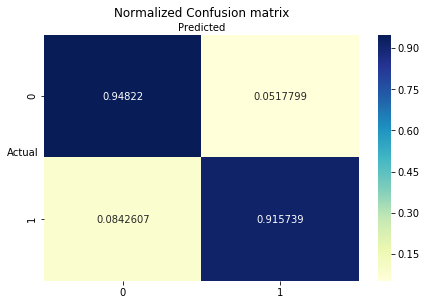

In [10]:
# Compute normalized confusion matrix
y_pred = model.predict(X_test_dense)
cnf_matrix = metrics.confusion_matrix(y_test, y_pred)
cm_normalized = cnf_matrix.astype('float')/cnf_matrix.sum(axis=1)[:,np.newaxis]


# name  of classes
class_names=['Fake','Real'] 

# Set fig and axes 
fig, ax = plt.subplots()
tick_marks = np.arange(len(class_names))
plt.xticks(tick_marks, class_names)
plt.yticks(tick_marks, class_names)

# Create heatmap
sns.heatmap(pd.DataFrame(cm_normalized), annot=True, cmap="YlGnBu" ,fmt='g')
ax.xaxis.set_label_position("top")
plt.tight_layout()
plt.title('Normalized Confusion matrix', y=1.1)
plt.ylabel('Actual',rotation=0)
plt.xlabel('Predicted');

print("ON TEST SET")




# Get top words in real news and fake news

In [13]:
# Initialize count vector

c_bin = CountVectorizer(tokenizer=lambda doc: doc,lowercase=False, binary = 'boolean')
c_bin_vectorizer = c_bin.fit(X_train)

In [16]:
# Transform and get the fetaure names of count vectorizer

X_train_bin = c_bin_vectorizer.transform(X_train)
X_train_bin = X_train_bin.toarray()
feature_names = c_bin.get_feature_names()

# Create a dataframe with count vector values for train set 
# and column names as feature names from count vector
df_train = pd.DataFrame(X_train_bin)
df_train.columns = feature_names

# Insert the labels of each article i.e real or fake
idx = 0
df_train.insert(loc = idx, column = 'labels',value = y_train)



In [18]:
# Split the above dataframe into two dataframes - 
# having real and fake articles (based on their label value)

df_fake = df_test.loc[df_test['labels'] == 0]

# Transpose so that now the words are in rows
df_fake = df_fake.T

# Get the count of each word
df_fake['fake_total'] = df_fake.sum(axis = 1)
df_fake = df_fake.drop(df_fake.index[0])
df_fake = df_fake['fake_total']

# Sort words from most frequest to least frequent
df_fake = df_fake.sort_values(ascending=False)

df_fake = df_fake.to_frame().reset_index()
df_fake.rename(columns={"index": "word"},inplace = True)




In [19]:
df_real = df_test.loc[df_test['labels'] == 1]

# Transpose so that now the words are in rows
df_real = df_real.T

# Get the count of each word
df_real['real_total'] = df_real.sum(axis = 1)
df_real = df_real.drop(df_real.index[0])
df_real = df_real['real_total']

# Sort words from most frequest to least frequent
df_real = df_real.sort_values(ascending=False)

df_real = df_real.to_frame().reset_index()
df_real.rename(columns={"index": "word"},inplace = True)




In [23]:
# Combine both dataframes based on the word in each row
df_both = pd.merge(df_real, df_fake, how='inner', on='word')

df_both

,word,real_total,fake_total
0,would,1287,921
1,one,1277,1021
2,state,1237,814
3,also,1220,856
4,new,1162,785
5,time,1159,936
6,people,1117,937
7,year,1110,828
8,president,1105,569
9,republican,1029,320


On one hand, there are words that are in 111 real news articles but just in 1 fake news article and one the other hand a word is in 1 real news article and 22 fake news articles.
<br>
In order to make a comparison of the words and their prominence in real and fake articles, knowing their prominence would help. Prominence can be calculated using the below formula:

###### prominence of a word = (count in real articles - count in fake artciles) / count in all articles



In [24]:
df_both['sub'] = df_both['real_total'] - df_both['fake_total']
df_both['perc'] = df_both['sub']/(df_both['real_total']+df_both['fake_total'])
df_both.sort_values(by = 'perc',ascending = False)

#Filter words that come only once
df_both = df_both[(df_both['perc'] > -1.0) & (df_both['perc'] < 1.0) & (df_both['perc'] != 0.000000) ]


,word,real_total,fake_total,sub,perc
1108,rand,111,1,110,0.982143
1332,boehner,92,1,91,0.978495
1775,fiorina,67,1,66,0.970588
1832,carly,64,1,63,0.969231
1977,gunman,58,1,57,0.966102
1197,presumptive,103,2,101,0.961905
408,rubio,251,5,246,0.960938
1224,mitch,100,2,98,0.960784
560,frontrunner,196,4,192,0.960000
435,marco,239,5,234,0.959016


The percentage in the last column will tell  the prominence of a word in the entire corpus – higher the score, higher the prominence; a positive score would mean prominence in real news as I subtracted fake count from real count, and negative score would mean prominence in fake news. Sorting the percentages in descending order, I could see the words that got most talked about in fake and in real news.

In [27]:
# Split words that have positive and negative prominence
# into real and fake (explained above)
df_top_real = df_both[(df_both['perc'] > 0.000001)]
df_top_fake = df_both[(df_both['perc'] < 0.000001)]

#Sort words according to their prominence score
df_top_real.sort_values(by='perc',ascending =False)


,word,real_total,fake_total,sub,perc
1108,rand,111,1,110,0.982143
1332,boehner,92,1,91,0.978495
1775,fiorina,67,1,66,0.970588
1832,carly,64,1,63,0.969231
1977,gunman,58,1,57,0.966102
1197,presumptive,103,2,101,0.961905
408,rubio,251,5,246,0.960938
1224,mitch,100,2,98,0.960784
560,frontrunner,196,4,192,0.960000
435,marco,239,5,234,0.959016


In [28]:
df_top_fake.sort_values(by='perc',ascending=True)



,word,real_total,fake_total,sub,perc
30069,rt,1,43,-42,-0.954545
21406,weiners,1,34,-33,-0.942857
28745,pertinent,1,28,-27,-0.931034
25078,indigenous,1,27,-26,-0.928571
29454,podestas,1,26,-25,-0.925926
28931,pictwittercom,1,26,-25,-0.925926
29271,baltic,1,25,-24,-0.923077
35752,paradigm,1,24,-23,-0.920000
35888,oligarch,1,20,-19,-0.904762
31076,republish,1,20,-19,-0.904762


# Visualization

In [1]:
performance = pickle_from('performance.pkl')
tr_performance = pickle_from('tr_performance.pkl')
val_performance = pickle_from('val_performance.pkl')

In [66]:
performance


,train_performance,val_performance,diff,model
logreg,0.907173,0.906884,0.000289,Logistic Regression
gb,0.879612,0.870806,0.008806,Gradient Boosting
nb,0.811918,0.798568,0.013350,Naive Bayes
rf,0.810595,0.767226,0.043369,Random Forest
svm,0.579477,0.510426,0.069051,Support Vector Classifier


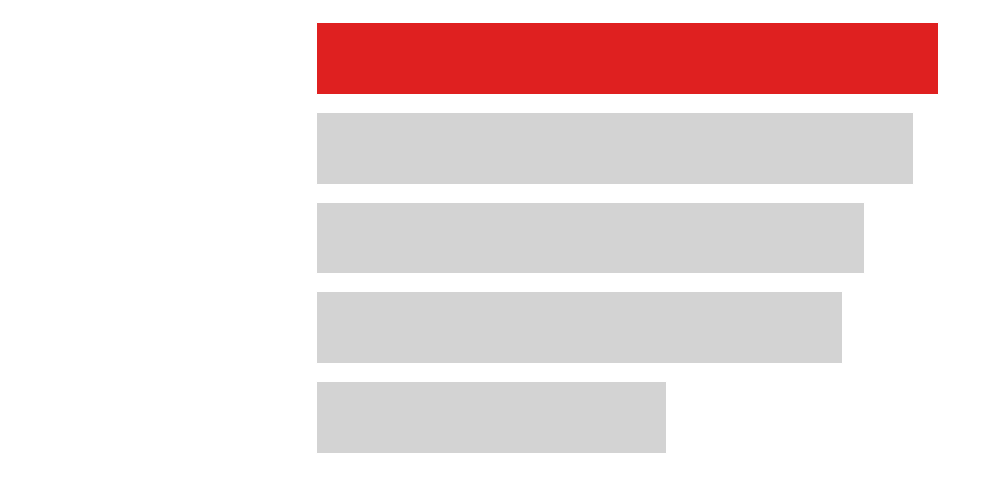

In [69]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style(style = 'white')
values = np.array(performance['val_performance'])
labels = np.array(performance['model'])
clrs = ['red' if (x == 'Logistic Regression') else 'lightgray' for x in labels]
ax = sns.barplot(y=performance['model'],x=performance['val_performance'],palette = clrs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(False)
ax.set_ylabel('')    
ax.set_xlabel('')
xlabels = [10,20,30,40,50,60,70,80]
ax.set_yticklabels(labels = labels,size =25,weight = 'bold',color = 'white')
ax.set_xticklabels(labels = xlabels , size = 25,weight = 'bold',color = 'white')
figure = ax.get_figure()    
# figure.savefig('ppt.png',dpi = 500, bbox_inches = 'tight',transparent = True)
plt.show();





In [700]:
pickle_to(df_fake,'df_fake.pkl')
pickle_to(df_real,'df_real.pkl')

Sucessfully saved to df_fake.pkl
Sucessfully saved to df_real.pkl


In [737]:
performance


,train_performance,val_performance,diff,model
gb,0.837609,0.820323,0.017286,Log Reg
nb_cvect,0.806037,0.794561,0.011476,Gradient Boosting
logreg,0.785995,0.775284,0.010711,Random Forest
pac,0.756285,0.738426,0.017859,Support Vector Classifier
svm,0.758698,0.728703,0.029995,Naive Bayes


In [111]:
name_1 = df_top_real[df_top_real['word']=='hillary']
name_1.drop('fake_total', axis=1, inplace=True)
name_1.drop('perc', axis=1, inplace=True)


In [112]:
name_2 = df_top_real[df_top_real['word'] == 'clinton']
name_2.drop('fake_total', axis=1, inplace=True)
name_2.drop('perc', axis=1, inplace=True)



In [113]:
frame = [name_1, name_2]
name = pd.concat(frame)
real_name = name[['word','real_total']]
fake_name = name[['word','sub']]



In [114]:
real_name.loc[real_name['real_total'] == 667, 'real_total'] = 12

real_name

,word,real_total
59,hillary,12
41,clinton,742


In [115]:
fake_name.loc[name['sub'] == 12, 'sub']  = 667


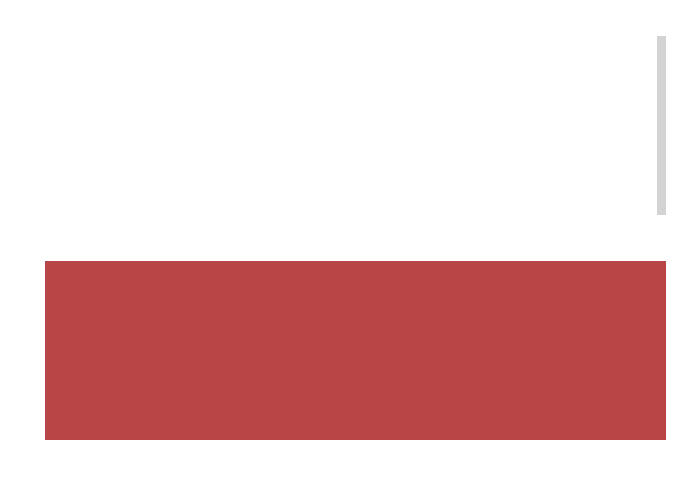

In [116]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style(style = 'white')
values = np.array(real_name['word'])
labels = np.array(real_name['real_total'])
clrs = ['#CC3333' if (x == 742) else 'lightgray' for x in labels]
ax = sns.barplot(y=real_name['word'],x=real_name['real_total'],palette = clrs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(False)
ax.set_ylabel('')    
ax.set_xlabel('')
ax.invert_xaxis()  # labels read top-to-bottom

xlabels = [100,200,300,400,500,600,700,800]
ylabels = ('')
ax.set_yticklabels(labels = ylabels,size =25,weight = 'bold',color = 'white')
ax.set_xticklabels(labels = xlabels , size = 25,weight = 'bold',color = 'white')
figure = ax.get_figure()    
figure.savefig('clinton.png',dpi = 500, bbox_inches = 'tight',transparent = True)
plt.show();






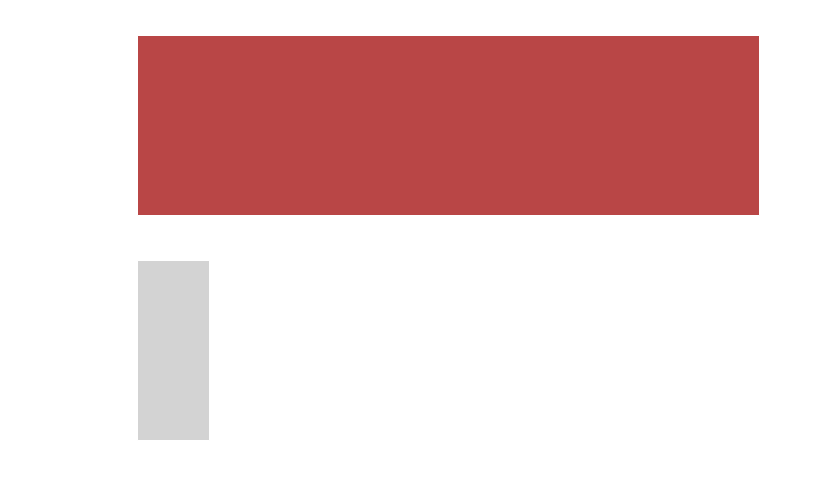

In [117]:
sns.set(rc={'figure.figsize':(11.7,8.27)})
sns.set_style(style = 'white')
values = np.array(fake_name['word'])
labels = np.array(fake_name['sub'])
clrs = ['#CC3333' if (x == 667) else 'lightgray' for x in labels]
ax = sns.barplot(y=fake_name['word'],x=fake_name['sub'],palette = clrs)
ax.spines['right'].set_visible(False)
ax.spines['top'].set_visible(False)
ax.spines['left'].set_visible(False)
ax.spines['bottom'].set_visible(False)
ax.grid(False)
ax.set_ylabel('')    
ax.set_xlabel('')
xlabels = [100,200,300,400,500,600,700,800]
ylabels = ['Hillary','Clinton']
ax.set_yticklabels(labels = ylabels,size =35,weight = 'bold',color = 'white')
ax.set_xticklabels(labels = xlabels , size = 25,weight = 'bold',color = 'white')
figure = ax.get_figure()    
figure.savefig('hillary.png',dpi = 500, bbox_inches = 'tight',transparent = True)
plt.show();







In [120]:
name

,word,real_total,sub
59,hillary,667,12
41,clinton,742,77


In [130]:
hillary = name[name['word'] == 'hillary']
hillary.columns = ['word','fake','real']
hillary = hillary[['word','real','fake']]


clinton = name [ name ['word'] == 'clinton']
clinton.columns = ['word','real','fake']


In [131]:
hillary

,word,real,fake
59,hillary,12,667


In [128]:
clinton

,word,real,fake
41,clinton,742,77
